#**Capital bike diaries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pygeohash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.2 MB/s eta 0:00:00


In [1]:
import os
from pathlib import Path
import scipy
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import sklearn
import folium
import pygeohash as pgh

##Cleaning and data integration

In [5]:
!cp -r "/content/drive/MyDrive/Dataset data" /content/


In [2]:
folder_path = Path('/content/Dataset data/')
#بيانات الرحلات اليومية
df_rent = pd.read_parquet(folder_path / "daily-rent.parquet") #df_rent: يحتوي على كافة الرحلات اليومية لاستئجار الدراجات
df_sampled_rent = pd.read_parquet(folder_path / "daily-rent-sampled.parquet") # نسخة مُصغّرة أو عيّنة من df_rent
#بيانات الطقس
df_weather = pd.read_csv(folder_path / "Washington,DC,USA 2024-01-01 to 2024-12-31.csv") # يحتوي على بيانات الطقس اليومية في واشنطن العاصمة من 1 يناير إلى 31 ديسمبر 2024.
#بيانات المحطات
df_stations_table = pd.read_csv(folder_path / "stations.csv") #جدول إضافي للمحطات، قد يحتوي على تفاصيل أخرى مثل معرّف المحطة (ID)، الاسم، عدد الأرصفة، إلخ
df_stations_info = pd.read_csv(folder_path / "Capital_Bikeshare_Locations.csv")  #معلومات حول مواقع محطات استئجار الدراجات الإحداثيات، اسم المحطة، إلخ.
#بيانات جغرافية ومناطق
df_cbd = gpd.read_file(folder_path / "DDOT_Central_Business_District.geojson") # المنطقة التجارية المركزية – تُستخدم لتحديد ما إذا كانت الرحلة بدأت أو انتهت داخل هذه المنطقة.
df_zones = gpd.read_file(folder_path / "Residential_and_Visitor_Parking_Zones.geojson") #مناطق وقوف السيارات السكنية والزوار (Residential and Visitor Parking Zones).
#بيانات النقل العام
df_metro = pd.read_csv(folder_path / "Metro_Bus_Stops.csv") #مواقف حافلات المترو (Metro Bus Stops).
df_shuttle = pd.read_csv(folder_path / "Shuttle_Bus_Stops.csv") # مواقف حافلات النقل الصغيرة (Shuttle Bus Stops).



In [4]:
df_rent.shape

(6114323, 13)

In [5]:
df_rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
dtypes: datetime64[ns](2), float64(4), string(7)
memory usage: 606.4 MB


In [6]:
df_rent.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng
count,6114323,6114323,6.114323e+06,6.114323e+06,6.109673e+06,6.109673e+06
mean,2024-07-18 16:52:01.082998016,2024-07-18 18:43:22.552895744,3.890560e+01,-7.703176e+01,3.890488e+01,-7.703157e+01
min,1970-01-01 00:00:00,2000-01-01 15:55:56,-8.960010e+01,-1.716215e+02,-8.839068e+01,-1.723373e+02
25%,2024-05-03 10:55:45.500000,2024-05-03 11:15:35.500000,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01
50%,2024-07-26 11:27:16.340999936,2024-07-26 11:47:01.260000,3.890550e+01,-7.703000e+01,3.890383e+01,-7.703000e+01
75%,2024-10-06 17:20:19.227500032,2024-10-06 17:41:45.916499968,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01
max,2024-12-31 23:54:46.421000,2030-01-01 00:00:00,8.582003e+01,5.993410e+01,8.957352e+01,5.730187e+01
std,NaN,NaN,2.178356e-01,2.281848e-01,2.219262e-01,2.403994e-01


In [7]:
print(df_rent.nunique())

ride_id               6114182
rideable_type               2
started_at            5866403
ended_at              5869571
start_station_name        818
start_station_id          803
end_station_name          818
end_station_id            803
start_lat              468450
start_lng              501510
end_lat                  1016
end_lng                  1045
member_casual               2
dtype: int64


In [8]:
print(df_rent.duplicated().sum())

0


In [9]:
print(df_rent.isnull().mean()*100)

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    19.478297
start_station_id      19.478297
end_station_name      20.217561
end_station_id        20.242535
start_lat              0.000000
start_lng              0.000000
end_lat                0.076051
end_lng                0.076051
member_casual          0.000000
dtype: float64


In [10]:
print(df_rent.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1190966
start_station_id      1190966
end_station_name      1236167
end_station_id        1237694
start_lat                   0
start_lng                   0
end_lat                  4650
end_lng                  4650
member_casual               0
dtype: int64


In [11]:
df_rent.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


<Axes: >

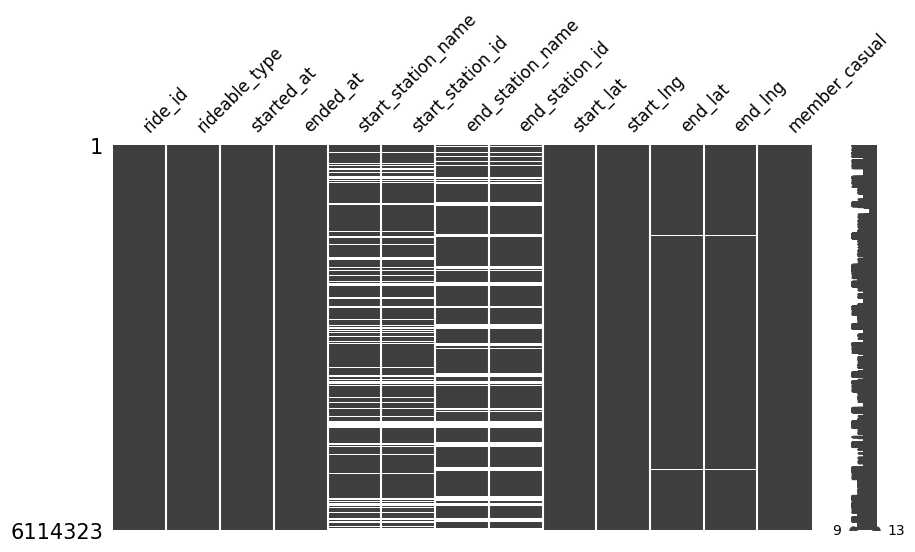

In [12]:
import missingno as msno
msno.matrix(df_rent,figsize=(10,5), fontsize=12)

<Axes: >

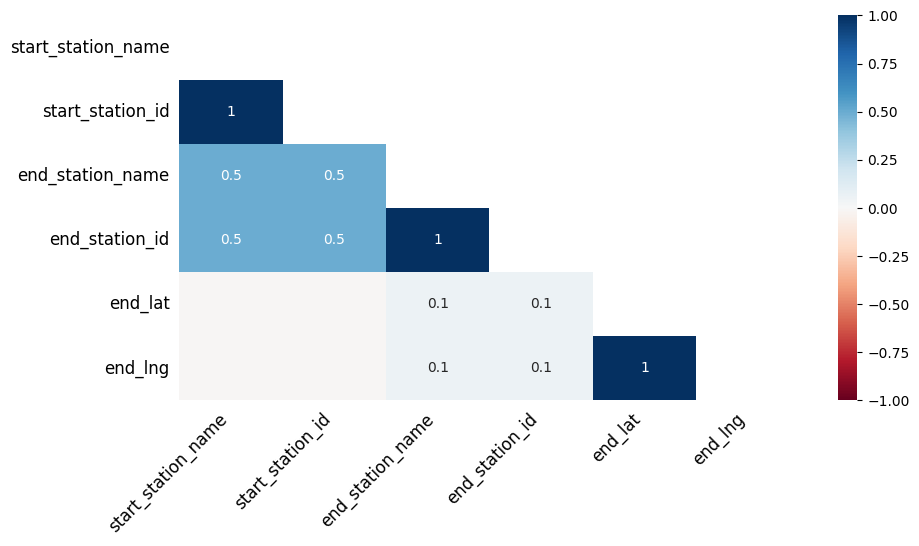

In [13]:
msno.heatmap(df_rent, figsize=(10,5), fontsize=12)

<Axes: >

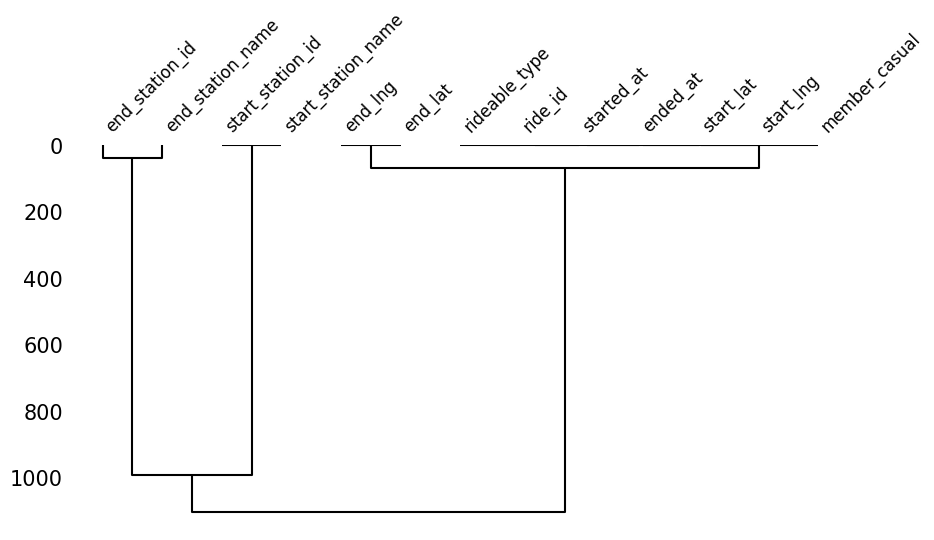

In [14]:
msno.dendrogram(df_rent, figsize=(10,5), fontsize=12)

In [3]:
# df_rent['end_lat'].fillna(df_rent['end_lat'].median(), inplace=True)
# df_rent['end_lng'].fillna(df_rent['end_lng'].median(), inplace=True)

<ipython-input-3-a5b2e66a39b2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_rent['end_lat'].fillna(df_rent['end_lat'].median(), inplace=True)
<ipython-input-3-a5b2e66a39b2>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [4]:
df_rent.fillna({
    'end_lat': df_rent['end_lat'].median(),
    'end_lng': df_rent['end_lng'].median()
}, inplace=True)

In [16]:
# df_rent["end_lat"]=df_rent["end_lat"].fillna(method='ffill')
# df_rent["end_lng"]=df_rent["end_lng"].fillna(method='ffill')

In [5]:
print(df_rent.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1190966
start_station_id      1190966
end_station_name      1236167
end_station_id        1237694
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
dtype: int64


In [6]:
categorical_cols = ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id']
df_rent[categorical_cols] = df_rent[categorical_cols].fillna(df_rent[categorical_cols].mode().iloc[0])

print(df_rent.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


In [19]:
print(df_rent.nunique())

ride_id               6114182
rideable_type               2
started_at            5866403
ended_at              5869571
start_station_name        818
start_station_id          803
end_station_name          818
end_station_id            803
start_lat              468450
start_lng              501510
end_lat                  1016
end_lng                  1045
member_casual               2
dtype: int64


In [20]:
df_rent.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


In [7]:
df_rent['start_station_id'] = df_rent['start_station_id'].astype('Int64')
df_rent['end_station_id'] = df_rent['end_station_id'].astype('Int64')

In [22]:
df_stations_table.shape

(821, 2)

In [23]:
df_stations_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [24]:
print(df_stations_table.nunique())

id      804
name    820
dtype: int64


In [25]:
print(df_stations_table.isnull().sum())

id      0
name    0
dtype: int64


In [26]:
df_stations_table.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [27]:
df_stations_info.shape

(794, 29)

In [28]:
df_stations_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [29]:
print(df_stations_info.nunique())

X                                 794
Y                                 794
NAME                              794
STATION_TYPE                        1
STATION_ID                        794
STATION_STATUS                      0
LAST_REPORTED                     125
NUM_DOCKS_AVAILABLE                33
NUM_DOCKS_DISABLED                  3
NUM_BIKES_AVAILABLE                31
NUM_EBIKES_AVAILABLE               10
NUM_BIKES_DISABLED                  8
IS_INSTALLED                        2
IS_RETURNING                        2
IS_RENTING                          2
HAS_KIOSK                           2
IOS                                 1
ANDROID                             1
ELECTRIC_BIKE_SURCHARGE_WAIVER      1
EIGHTD_HAS_KEY_DISPENSER            1
CAPACITY                           29
RENTAL_METHODS                      1
REGION_ID                           8
REGION_NAME                         1
GIS_ID                              0
LATITUDE                          789
LONGITUDE   

In [30]:
print(df_stations_info.isnull().sum())

X                                   0
Y                                   0
NAME                                0
STATION_TYPE                        0
STATION_ID                          0
STATION_STATUS                    794
LAST_REPORTED                       0
NUM_DOCKS_AVAILABLE                 0
NUM_DOCKS_DISABLED                  0
NUM_BIKES_AVAILABLE                 0
NUM_EBIKES_AVAILABLE                0
NUM_BIKES_DISABLED                  0
IS_INSTALLED                        0
IS_RETURNING                        0
IS_RENTING                          0
HAS_KIOSK                           0
IOS                                 0
ANDROID                             0
ELECTRIC_BIKE_SURCHARGE_WAIVER      0
EIGHTD_HAS_KEY_DISPENSER            0
CAPACITY                            0
RENTAL_METHODS                      0
REGION_ID                          50
REGION_NAME                         0
GIS_ID                            794
LATITUDE                            0
LONGITUDE   

In [31]:
df_stations_info.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [32]:
# # مثال: إزالة مسافات زائدة وتحويل إلى حروف صغيرة
# df_stations_info['clean_name'] = df_stations_info['NAME'].str.strip().str.lower()
# df_stations_table['clean_name'] = df_stations_table['name'].str.strip().str.lower()

# # الآن حاول الدمج باستخدام الأسماء المنظفة
# merged_df = pd.merge(df_stations_info, df_stations_table, left_on='clean_name', right_on='clean_name', how='left')


In [8]:
merged_df = pd.merge(df_stations_info, df_stations_table, left_on='NAME', right_on='name', how='left')

df_stations_info['id'] = merged_df['id']


In [34]:
df_stations_info.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID,id
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028,31258.0
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029,32220.0
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030,31290.0
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031,31270.0
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032,31708.0


In [35]:
no_match = df_stations_info[df_stations_info['id'].isnull()]
print(no_match[['NAME']])

                                                  NAME
12                         Martha Custis Dr & Lyons Ln
19                                Herndon Metro South 
65                              D St & Maryland Ave NE
67       1301 McCormick Dr / Wayne K. Curry Admin Bldg
109                    Columbia Pike & S Greenbrier St
156                                     23rd & M St NW
182                  Traville Gateway Dr & Gudelsky Dr
262                       Becontree Ln & Goldenrain Ct
276                                      3rd & G St SE
294                                5th & Kennedy St NW
346             Wheaton Library & Community Rec Center
358                             4th St & Madison Dr NW
426  Alabama Ave & Stanton Rd SE / Shops at Park Vi...
477                            Braddock Rd Metro South
541                  Washington Blvd & Walter Reed Dr 
616                                      1st & I St SE
667                                    3rd & Elm St NW
737       

In [9]:
df_stations_info['id'] = df_stations_info['id'].astype('Int64')

In [10]:
df_merged_start = pd.merge(
    df_rent,                      # الجدول الأول (الرحلات)
    df_stations_info,                      # الجدول الثاني (المحطات)
    left_on='start_station_id',
    right_on='id',
    how='left',
    suffixes=('', '_start')    # إضافة بادئة لأعمدة المحطة البدائية
)

In [11]:
df_merged_end = pd.merge(
    df_rent,                      # الجدول الأول (الرحلات)
    df_stations_info,                      # الجدول الثاني (المحطات)
    left_on='end_station_id',
    right_on='id',
    how='left',
    suffixes=('', '_end')    # إضافة بادئة لأعمدة المحطة البدائية
)

In [14]:
df_merged_end.isnull().sum()

,0
ride_id,0
rideable_type,0
started_at,0
ended_at,0
start_station_name,0
start_station_id,0
end_station_name,0
end_station_id,0
start_lat,0
start_lng,0


##Exploration and Analysis

##Pattern discovery